# Toxicity - Argument Quality Timeseries Analysis

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import re
import shutil

import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import scikit_posthocs as sp

import tasks.stats
import tasks.postprocessing
import tasks.graphs

In [2]:
tqdm.tqdm.pandas()
sns.set(style="whitegrid")

In [3]:
from tasks.constants import *


TOXICITY_TICKS = np.arange(1, 6, 1)
YTICKS_LIST = [TOXICITY_TICKS, TOXICITY_TICKS]
VMIN_TOXICITY = -1
VMAX_TOXICITY = 1

## Preprocessing

In [4]:
full_df = tasks.postprocessing.get_main_dataset()
full_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened
0,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,4,3,False
1,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,False
2,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,False
3,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,False
4,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,4,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57316,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False
57317,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False
57318,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False
57319,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False


In [5]:
df = full_df[~full_df.not_intervened]
df.shape

(56375, 13)

In [6]:
no_hardocoded_df = full_df[full_df.model != "hardcoded"]

In [7]:
no_mod_df = no_hardocoded_df.copy()
no_mod_df = no_mod_df[~no_mod_df.is_moderator]
contains_mod = no_mod_df.conv_variant != "No Moderator"
no_mod_df.loc[contains_mod, "message_order"] = (
    no_mod_df[contains_mod].message_order // 2 + 1
)

## Aggregated Analysis

### User intent impact on toxicity

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_barplot.png


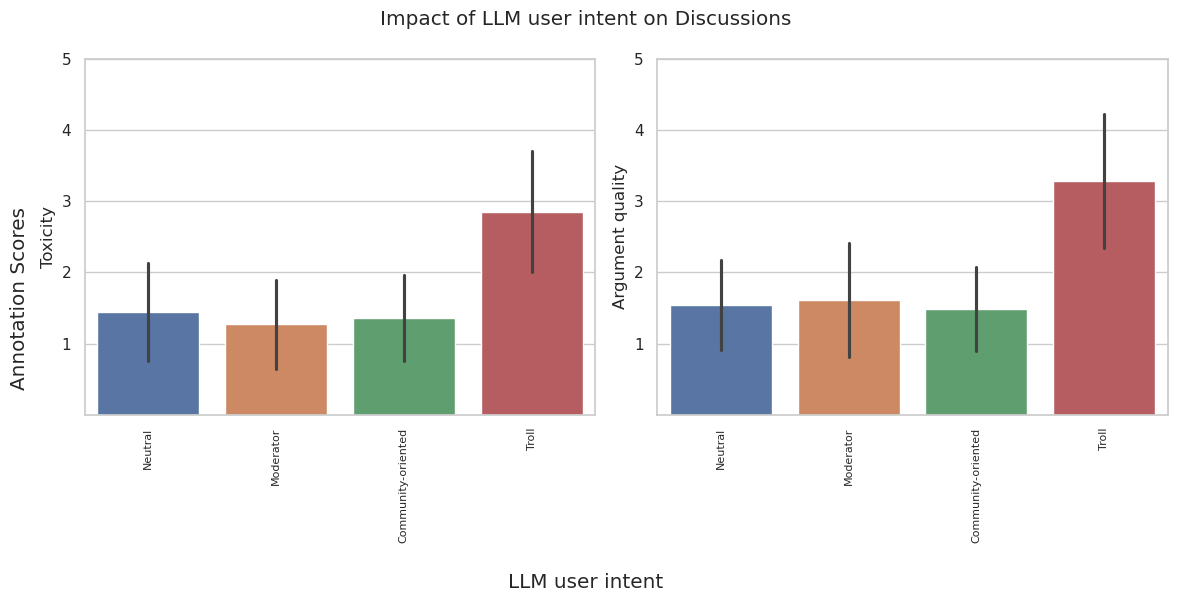

In [8]:
tasks.graphs.plot_metrics_barplots(
    df=no_hardocoded_df,
    group_by_col="intent",
    group_by_col_label="LLM user intent",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "intent_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/strategy_barplot.png


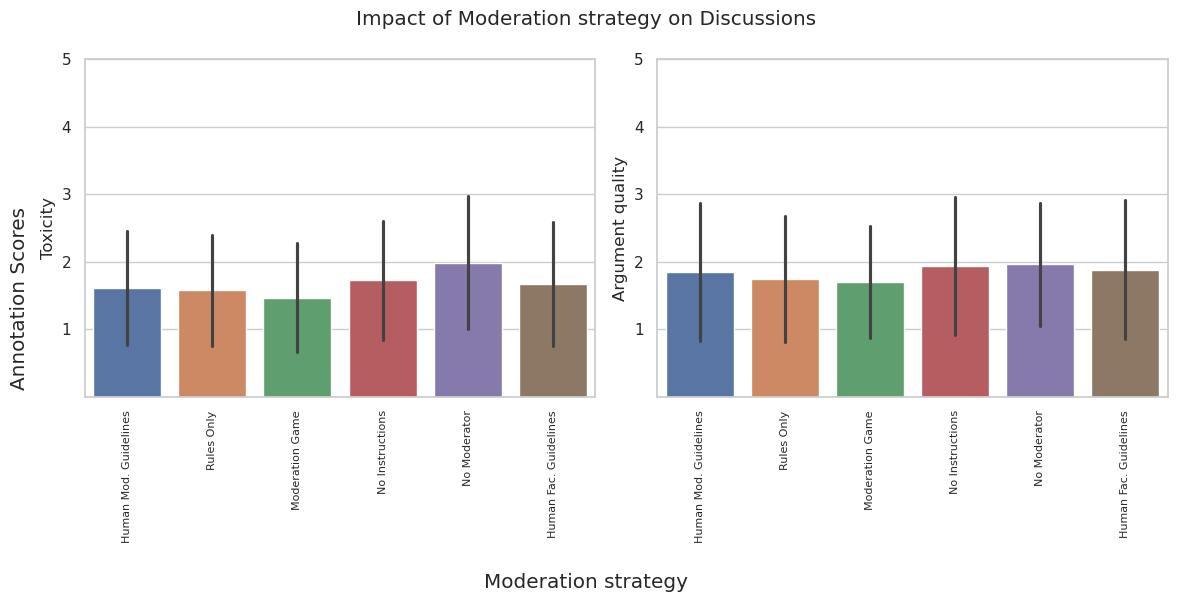

In [9]:
tasks.graphs.plot_metrics_barplots(
    df=no_mod_df,
    group_by_col="conv_variant",
    group_by_col_label="Moderation strategy",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "strategy_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/model_barplot.png


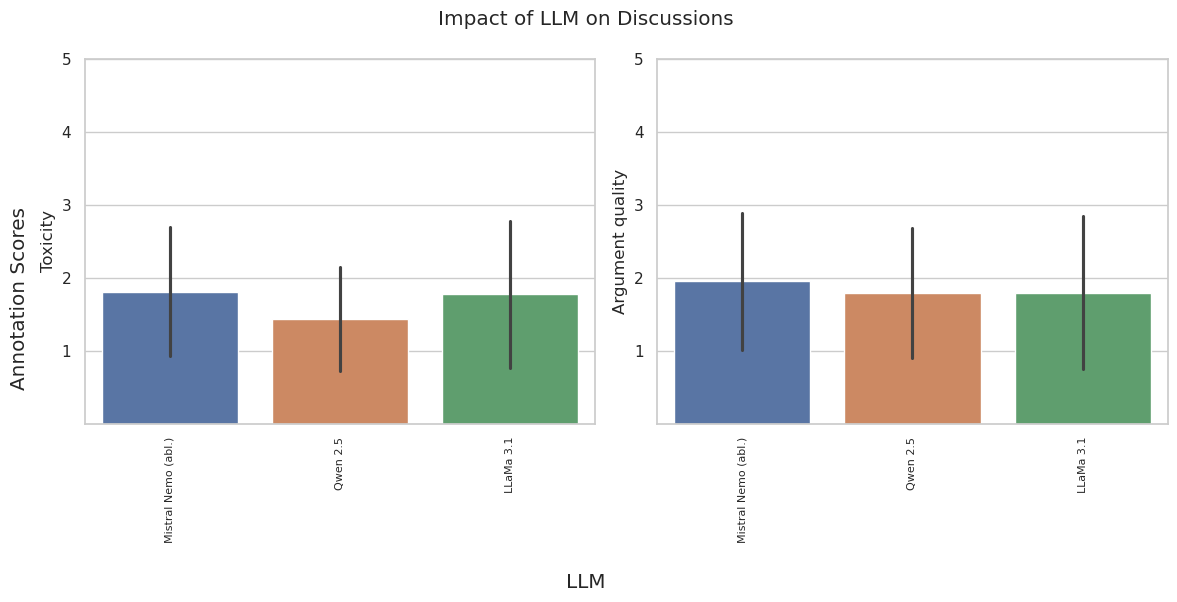

In [10]:
tasks.graphs.plot_metrics_barplots(
    df=no_mod_df,
    group_by_col="model",
    group_by_col_label="LLM",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "model_barplot.png")
plt.show()

## Timeseries analysis

### Role

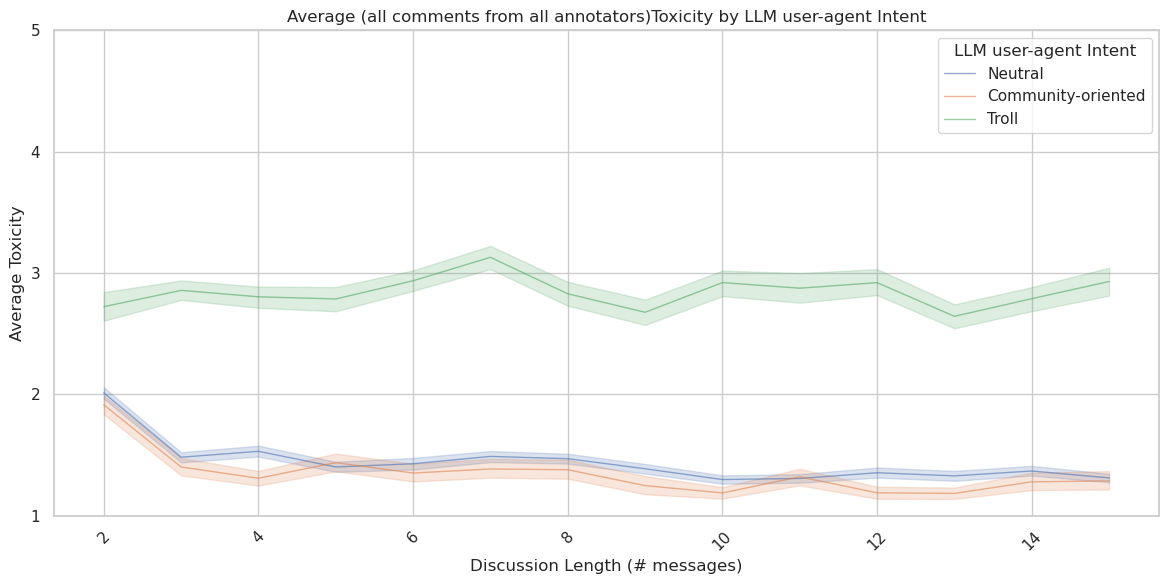

In [ ]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Toxicity",
    hue_col="intent",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

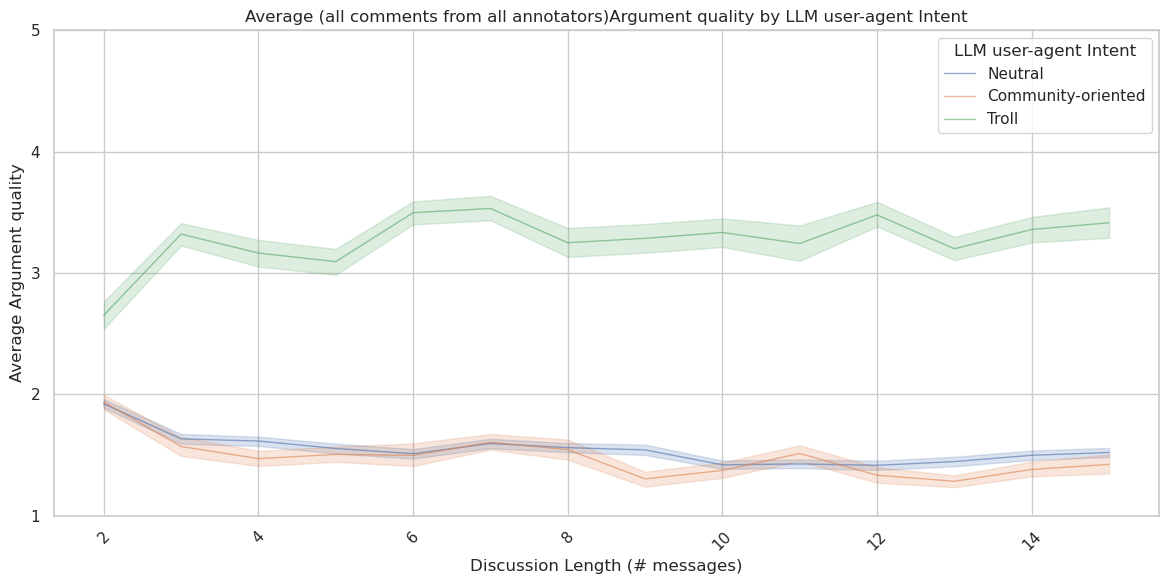

In [12]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Argument Quality",
    hue_col="intent",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

### Moderation Strategy

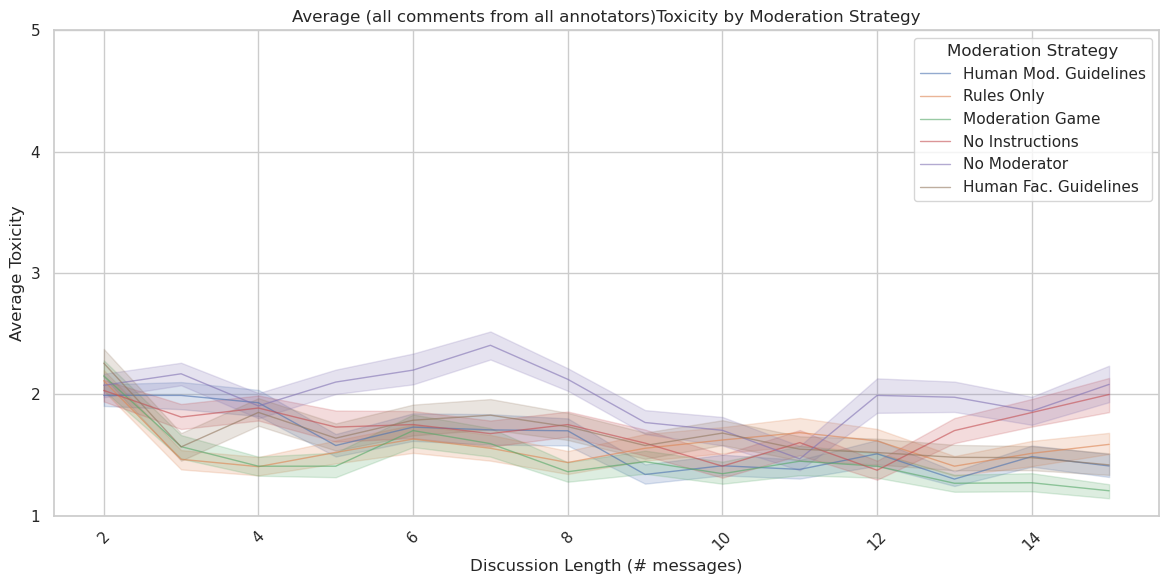

In [13]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Toxicity",
    hue_col="conv_variant",
    hue_col_label="Moderation Strategy",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

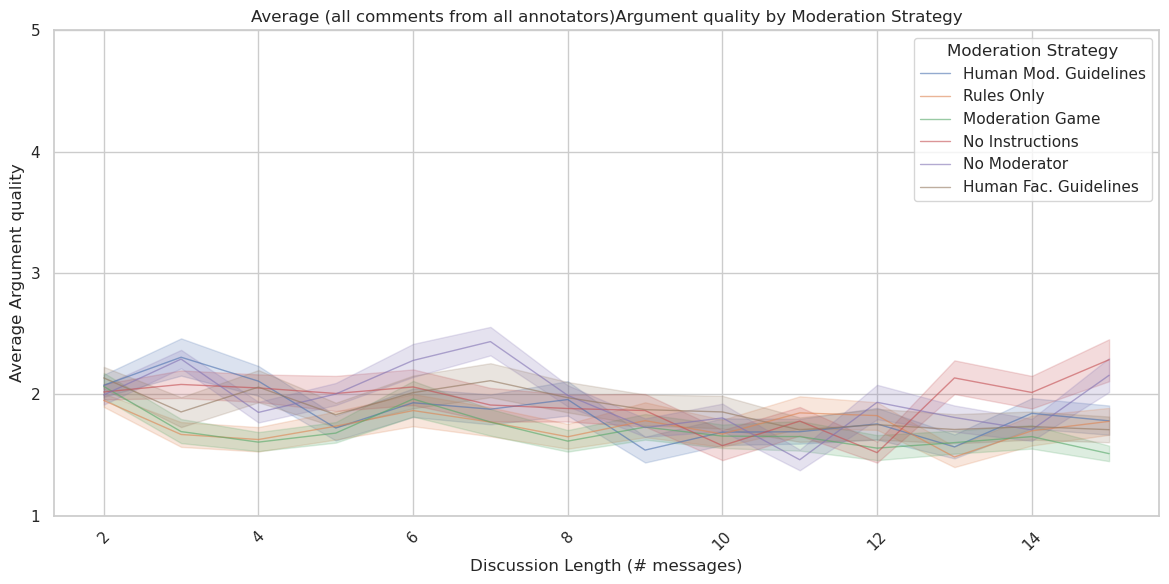

In [14]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Argument Quality",
    hue_col="conv_variant",
    hue_col_label="Moderation Strategy",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

### Models

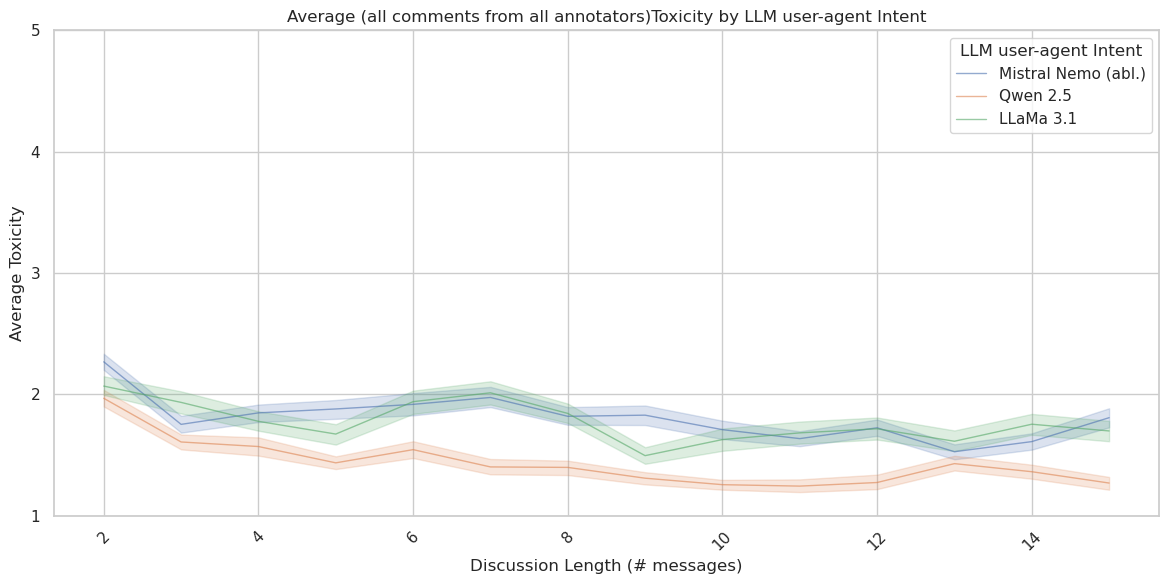

In [15]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Toxicity",
    hue_col="model",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

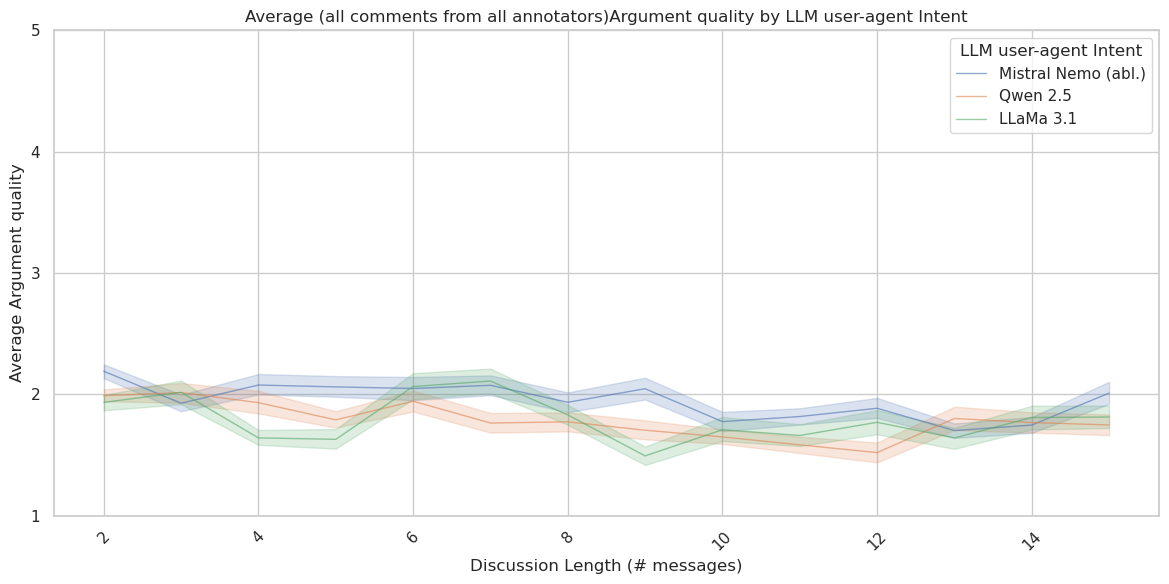

In [16]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Argument Quality",
    hue_col="model",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

## Annotator analysis

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/annotator_variance.png


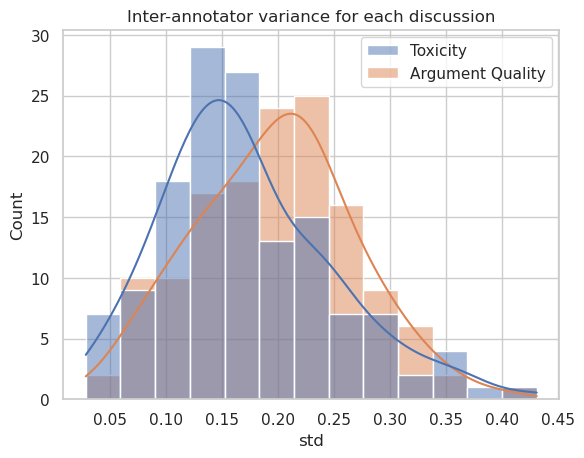

In [17]:
toxicity_var = tasks.stats.discussion_var(
    df, "conv_id", "message_id", "Toxicity"
)
argumentq_var = tasks.stats.discussion_var(
    df, "conv_id", "message_id", "Argument Quality"
)

sns.histplot([toxicity_var, argumentq_var], kde=True)
plt.title("Inter-annotator variance for each discussion")
plt.xlabel("std")

tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "annotator_variance.png")
plt.show()